<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/TSSD_Deep_Quantile_Regression_Anomaly_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deep Quantile Regression

We are try to predict the Taxi demand in NYC in a critical time period.

From [Marco Cerliani](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_LSTM/Anomaly_Detection_LSTM.ipynb)


In [ ]:
!wget -q https://www.dropbox.com/s/1l95lwqjhaz6y1x/nyc_taxi.csv

In [ ]:
import os
import tqdm
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

## Loading data and creating features

In [ ]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###

df = pd.read_csv('nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df.timestamp.dt.hour

print(df.shape)
df.head()

(10320, 6)


,timestamp,value,yr,mt,d,H
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


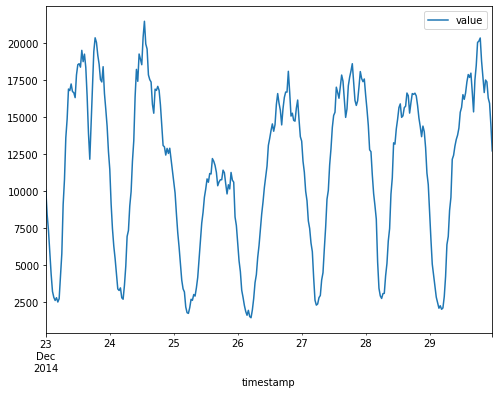

In [ ]:
### PLOT SAMPLE OF DATA ###

df.iloc[8400:8400+7*48,:].plot(y='value', x='timestamp', figsize=(8,6))

## Checking the correlation of the weeks

As we can see there is are clear recurring patterns

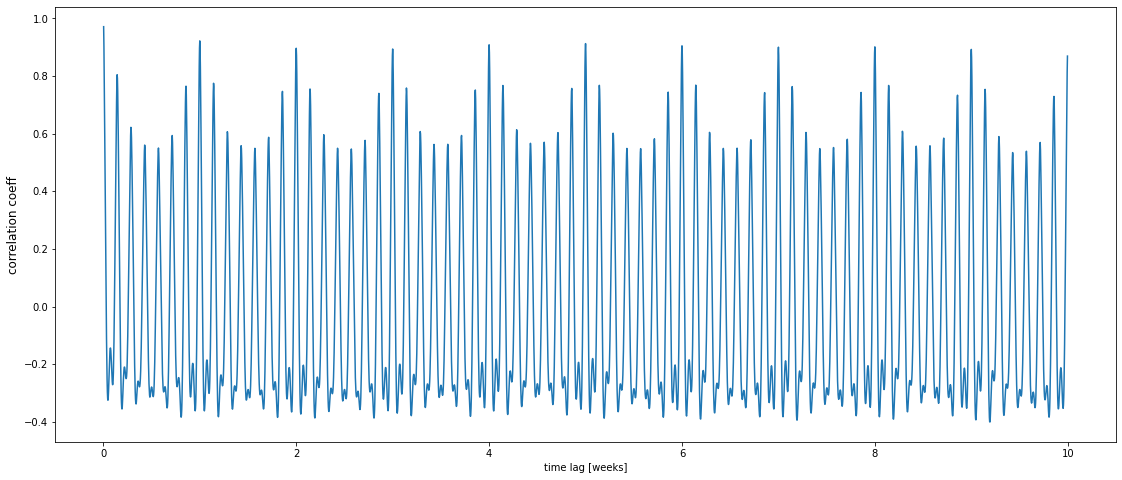

In [ ]:
### WEEKLY AUTOCORR PLOT (10 WEEKS DEPTH) ###

timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

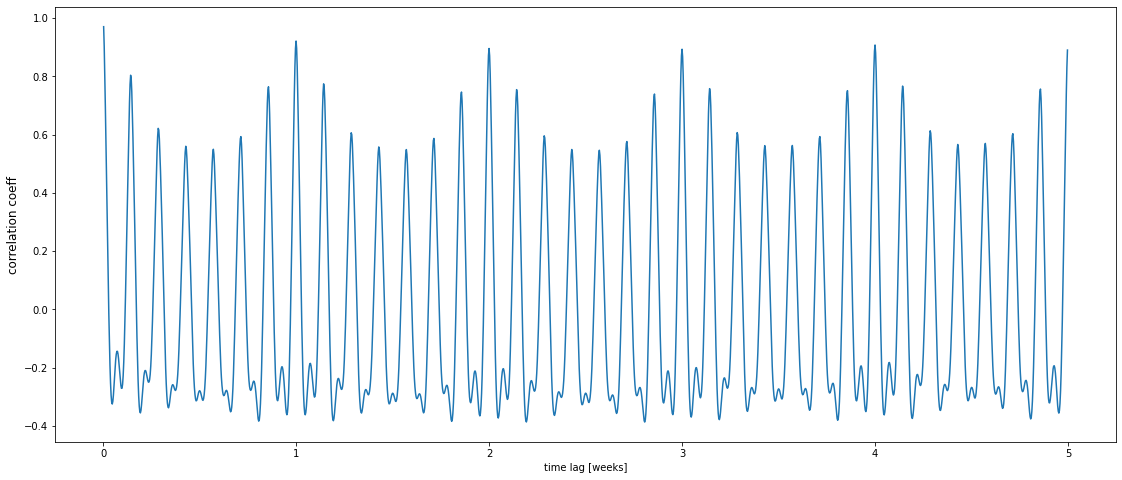

In [ ]:
timeLags = np.arange(1,5*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); plt.ylabel('correlation coeff', fontsize=12);

In [ ]:
### CREATE WEEKDAY FEATURE AND COMPUTE THE MEAN FOR WEEKDAYS AT EVERY HOURS ###

df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

In [ ]:
### CREATE GENERATOR FOR LSTM ###

sequence_length = 48


def gen_index(id_df, seq_length, seq_cols):

    data_matrix =  id_df[seq_cols]
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length, 1), range(seq_length, num_elements, 1)):
        
        yield data_matrix[stop-sequence_length:stop].values.reshape((-1,len(seq_cols)))

In [ ]:
### CREATE AND STANDARDIZE DATA FOR LSTM ### 

cnt, mean = [], []
for sequence in gen_index(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_index(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

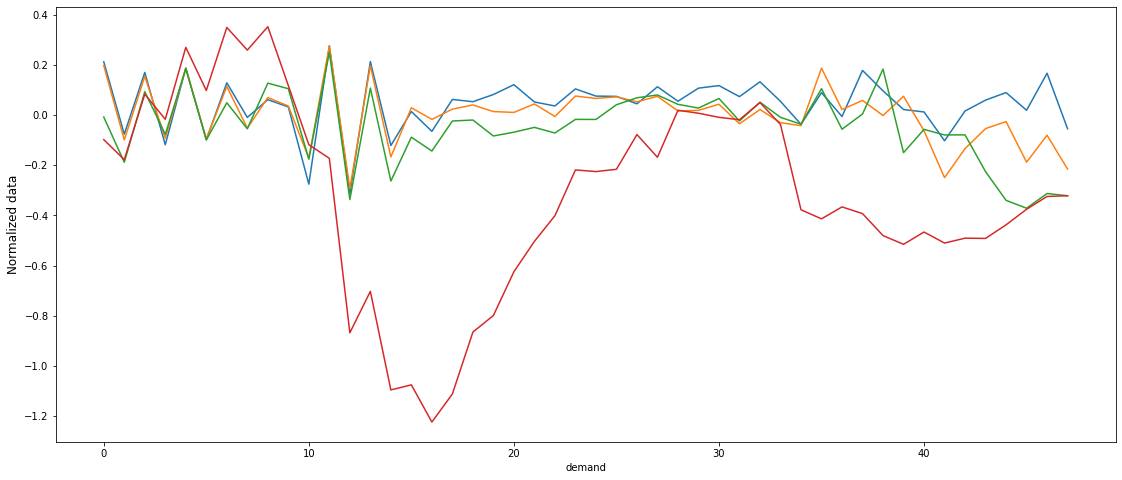

In [ ]:
cnt[0]

plt.figure(figsize=(19,8))
plt.plot(cnt[0]);
plt.plot(cnt[48]);
plt.plot(cnt[96]);
plt.plot(cnt[144]);
plt.xlabel('demand'); plt.ylabel('Normalized data', fontsize=12);

In [ ]:
### CREATE AND STANDARDIZE LABEL FOR LSTM ###

init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

In [ ]:
label[0:3]


array([ 0.19651303, -0.09943045,  0.15379559])

In [ ]:
# set seeds
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

## Creating the Quantile / Pinball Loss

In [ ]:
### DEFINE QUANTILE LOSS ###
# q = tau 
def q_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [ ]:
### TRAIN TEST SPLIT ###

X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]
train_date, test_date = df.timestamp.values[sequence_length:5000+sequence_length], df.timestamp.values[5000+sequence_length:]

In [ ]:
set_seed(42)

In [ ]:

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.5))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)


model = Model(inputs, [out10,out50,out90])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 48, 128)      33792       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32)           18560       bidirectional[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           1650        bidirectional_1[0][0]            
______________________________________________________________________________________________

In [ ]:
losses = [lambda y,f: q_loss(0.1,y,f), 
          lambda y,f: q_loss(0.5,y,f), 
          lambda y,f: q_loss(0.9,y,f)]


model.compile(loss=losses, 
              optimizer='adam', 
              loss_weights = [0.33,0.33,0.33])



In [ ]:
model.fit(X_train, 
          [y_train,y_train,y_train], 
          epochs=50, 
          batch_size=128, 
          verbose=2)

Epoch 1/50
40/40 - 22s - loss: 0.0314 - dense_1_loss: 0.0272 - dense_2_loss: 0.0439 - dense_3_loss: 0.0240
Epoch 2/50
40/40 - 1s - loss: 0.0291 - dense_1_loss: 0.0240 - dense_2_loss: 0.0423 - dense_3_loss: 0.0220
Epoch 3/50
40/40 - 1s - loss: 0.0282 - dense_1_loss: 0.0229 - dense_2_loss: 0.0409 - dense_3_loss: 0.0217
Epoch 4/50
40/40 - 1s - loss: 0.0278 - dense_1_loss: 0.0222 - dense_2_loss: 0.0408 - dense_3_loss: 0.0213
Epoch 5/50
40/40 - 1s - loss: 0.0275 - dense_1_loss: 0.0220 - dense_2_loss: 0.0403 - dense_3_loss: 0.0211
Epoch 6/50
40/40 - 1s - loss: 0.0273 - dense_1_loss: 0.0218 - dense_2_loss: 0.0404 - dense_3_loss: 0.0206
Epoch 7/50
40/40 - 1s - loss: 0.0269 - dense_1_loss: 0.0212 - dense_2_loss: 0.0396 - dense_3_loss: 0.0205
Epoch 8/50
40/40 - 1s - loss: 0.0266 - dense_1_loss: 0.0212 - dense_2_loss: 0.0392 - dense_3_loss: 0.0201
Epoch 9/50
40/40 - 1s - loss: 0.0258 - dense_1_loss: 0.0204 - dense_2_loss: 0.0384 - dense_3_loss: 0.0194
Epoch 10/50
40/40 - 1s - loss: 0.0260 - dense

In [ ]:
# 48 half hours
print(X_test.shape)


(5272, 48, 1)


## We now predict for each quantile over the test set a 100 times

In [ ]:
### QUANTILEs BOOTSTRAPPING ###
pred_10 = []
pred_50 = []
pred_90 = []

for i in tqdm.tqdm(range(0,100)):
    predd = model.predict(X_test)
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])



100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


In [ ]:
pred_10[0].shape, len(pred_10),len(pred_50),len(pred_90)

((5272, 1), 100, 100, 100)

In [ ]:
pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]

In [ ]:
pred_10.shape, pred_50.shape

((100, 5272), (100, 5272))

In [ ]:
### REVERSE TRANSFORM PREDICTIONS ###

pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [ ]:
pred_10_m.shape, pred_50_m.shape

((5272,), (5272,))

In [ ]:
def check_a_point(num):
  print(pred_10_m[num], pred_50_m[num], pred_90_m[num])

check_a_point(0)
check_a_point(100)
check_a_point(1000)

1501.6783303269494 1961.5999595584387 2505.0313645528904
5178.395879744879 7164.509151134649 9327.878611258402
7682.4775317164895 9292.393993830132 11255.915251096545


In [ ]:
### EVALUATION METRIC ###

mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.07788038026908009

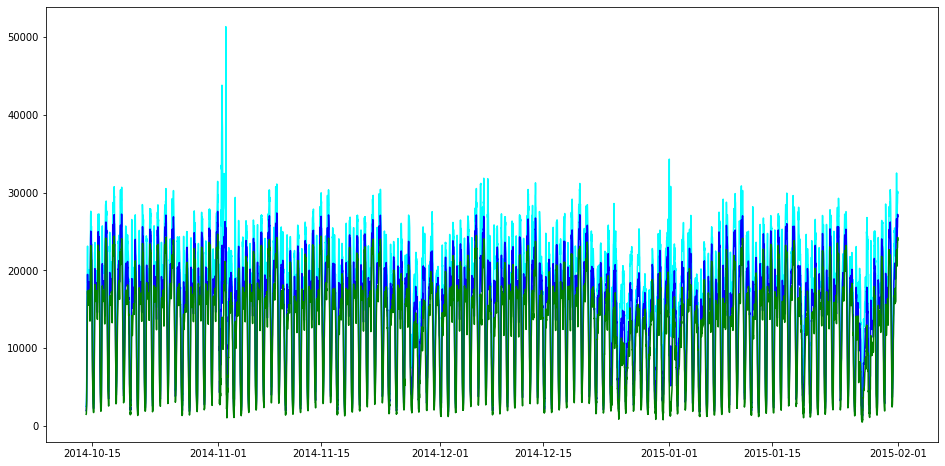

In [ ]:
### PLOT QUANTILE PREDICTIONS ###

plt.figure(figsize=(16,8))
plt.plot(test_date, pred_90_m, color='cyan')
plt.plot(test_date, pred_50_m, color='blue')
plt.plot(test_date, pred_10_m, color='green')


### CROSSOVER CHECK ###

plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

## Compare to the test data

The quantile interval becomes higher in periods of uncertainty. This allows us to see anomalies early.

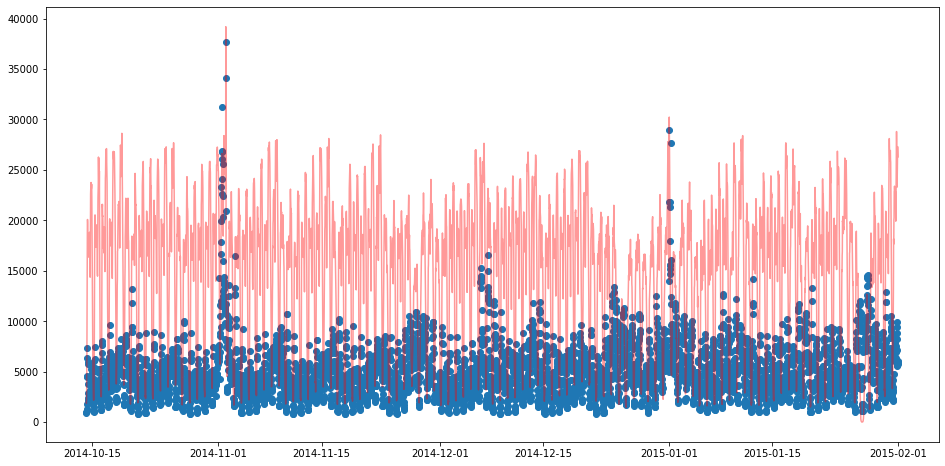

In [ ]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

plt.figure(figsize=(16,8))
plt.plot(test_date, np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(test_date, pred_90_m - pred_10_m)